In [1]:
import tensorflow as tf
import os

2023-11-01 03:31:06.204643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 03:31:06.326970: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-01 03:31:06.785781: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-01 03:31:06.785829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
# Avoid OOM errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) # to tell tensorflow to allocate memory as needed

2023-11-01 03:31:07.461647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-01 03:31:07.468235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-01 03:31:07.468388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
import cv2

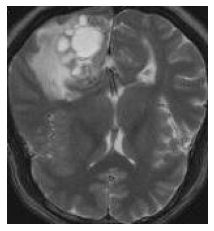

In [4]:
data_dir = 'preprocessed'
# open a random brain image, check if image has been processed
# grayscale -> gaussianBlur -> binary threshold -> erosion -> dilate -> contour
# Crop
img_raw = os.path.join(data_dir, 'malignant', 'y718.jpg')
img = cv2.imread(img_raw)

import matplotlib.pyplot as plt
# Convert image to normal
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)

In [5]:
# for image_class in os.listdir(data_dir):
#     class_dir = os.path.join(data_dir, image_class)
#     for image in os.listdir(class_dir):
#         image_path = os.path.join(class_dir, image)
#         try:
#             tip = imghdr.what(image_path)
#             if tip not in image_extensions:
#                 os.remove(image_path)
#                 print("Removed (invalid format):", image_path)
#             else:
#                 img = cv2.imread(image_path)
#                 if img is None:
#                     os.remove(image_path)
#                     print("Removed (unable to read):", image_path)
#         except Exception as e:
#             print("Error processing:", image_path, "-", str(e))

In [6]:
import numpy as np
from matplotlib import pyplot as plt

In [7]:
# Building the data pipeline
# Reshapes the images to the same size, and normalizes the pixel values to a range of 0 to 1.
data = tf.keras.utils.image_dataset_from_directory('preprocessed')
valid = tf.keras.utils.image_dataset_from_directory('valid')

Found 2904 files belonging to 2 classes.
Found 24 files belonging to 2 classes.


2023-11-01 03:31:08.107862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 03:31:08.108637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-01 03:31:08.108832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-01 03:31:08.108956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [8]:
# Accessing the data pipeline
data_iterator = data.as_numpy_iterator()

In [9]:
# Accessing the data itself in the pipeline
batch = data_iterator.next()

In [10]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [11]:
# Class 0 means benign images and Class 1 means malignant
batch[1]

array([1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0], dtype=int32)

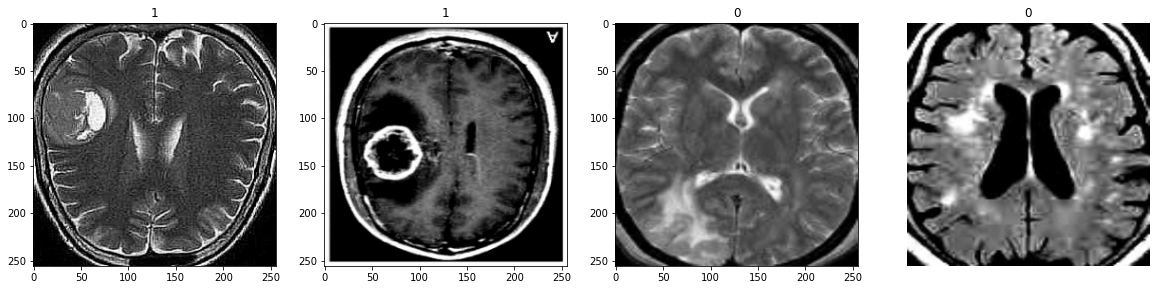

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
plt.axis('off')
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    plt.axis('off')

In [13]:
data = data.map(lambda x, y: (x/255, y))
valid = tf.keras.utils.image_dataset_from_directory('valid')
valid = valid.map(lambda x, y: (x/255, y))

Found 24 files belonging to 2 classes.


In [14]:
scaled_iterator = data.as_numpy_iterator()

In [15]:
batch = scaled_iterator.next()

In [16]:
batch[0].min()

0.0

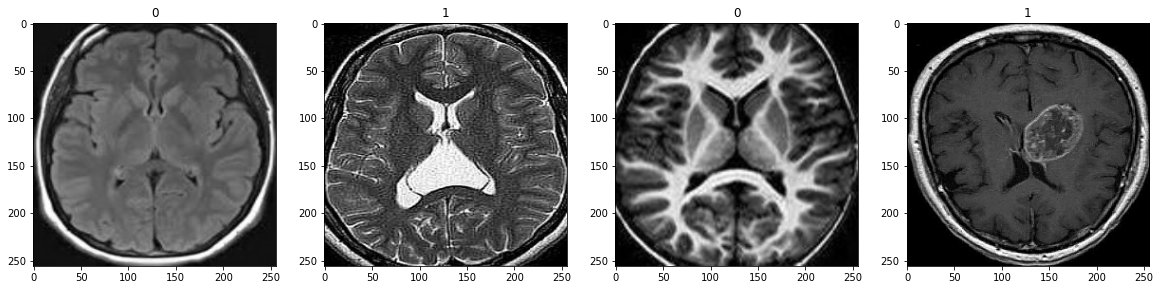

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [18]:
len(data)

91

In [19]:
train_size = int(len(data))
val_size = int(len(valid))

In [20]:
print(train_size)
print(val_size)

91
1


In [21]:
train = data.take(train_size)
validation = valid.take(val_size)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

In [23]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Adding dropout for regularization
model.add(Dense(1, activation='sigmoid'))

In [24]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [26]:
logdir = 'logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train, epochs=20, validation_data=validation, callbacks=[tensorboard_callback])
# hist = model.fit(train, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20


2023-11-01 03:31:10.590311: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8202
2023-11-01 03:31:10.795332: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-01 03:31:12.056829: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


90/91 [============================>.] - ETA: 0s - loss: 0.7271 - accuracy: 0.6809

2023-11-01 03:31:23.731637: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


91/91 [==============================] - 14s 131ms/step - loss: 0.7239 - accuracy: 0.6822 - val_loss: 0.7741 - val_accuracy: 0.5000
Epoch 2/20
91/91 [==============================] - 11s 121ms/step - loss: 0.3674 - accuracy: 0.8499 - val_loss: 0.2829 - val_accuracy: 0.8750
Epoch 3/20
91/91 [==============================] - 11s 121ms/step - loss: 0.2665 - accuracy: 0.8981 - val_loss: 0.4574 - val_accuracy: 0.7083
Epoch 4/20
91/91 [==============================] - 11s 122ms/step - loss: 0.1830 - accuracy: 0.9263 - val_loss: 0.3057 - val_accuracy: 0.9583
Epoch 5/20
91/91 [==============================] - 12s 126ms/step - loss: 0.1182 - accuracy: 0.9539 - val_loss: 0.1474 - val_accuracy: 0.9583
Epoch 6/20
91/91 [==============================] - 12s 131ms/step - loss: 0.0714 - accuracy: 0.9745 - val_loss: 0.1436 - val_accuracy: 0.9167
Epoch 7/20
91/91 [==============================] - 12s 129ms/step - loss: 0.0570 - accuracy: 0.9821 - val_loss: 0.1054 - val_accuracy: 0.9583
Epoch 8/20

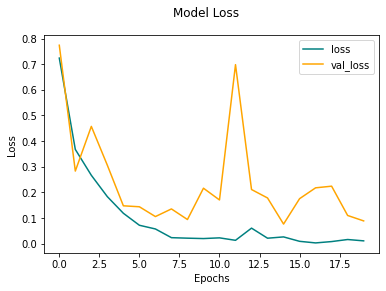

In [29]:
# Plot the model performance
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

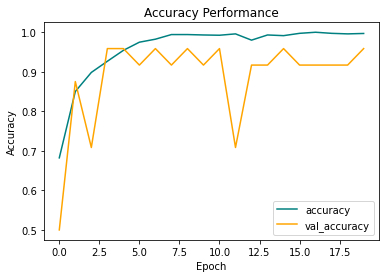

In [30]:
# Plot the accuracy performance
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Accuracy Performance')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [32]:
# Only if test set exists as tensors
# true_labels = []
# for image, label in test:
#     # `image` contains the image data
#     # `label` contains the label
#     print(f"Label: {label.numpy()}")
#     true_labels.append(label.numpy())

# true_labels = np.array(true_labels)
# print(true_labels)

In [33]:
test_dir = 'test'

In [34]:
test_images = []
true_labels = []
file_names = []

for label in os.listdir(test_dir):
    for file in os.listdir(os.path.join(test_dir, label)):
            img = cv2.imread(os.path.join(test_dir, label, file))
            resize = tf.image.resize(img, [256, 256])
            test_images.append(resize)
            true_labels.append(label)
            file_names.append(file)

In [35]:
print(len(test_images), len(true_labels), len(file_names))
print(true_labels)

# Get index of first malignant image
index = true_labels.index('malignant')
print(index, file_names[index])

47 47 47
['benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant']
16 49.jpg


In [36]:
true = [1 if label == 'malignant' else 0 for label in true_labels]
true[15]

0

In [37]:
predictions = []
for predict in test_images:
    prediction = model.predict(np.expand_dims(predict/255, 0))
    predictions.append(prediction[0][0])

print(predictions)

1/1 [==============================] - 0s 13ms/step
[0.00017711174, 0.99297756, 4.8866404e-09, 2.7519375e-06, 6.3790695e-10, 0.8620392, 0.00027159057, 0.00047319193, 2.5159763e-11, 0.07841789, 0.0044972226, 0.0025328659, 0.00019131709, 0.9094413, 0.021019228, 7.014524e-11, 0.99988616, 0.99117684, 0.9999956, 0.99976414, 1.0, 0.55103725, 1.0, 1.0, 0.9999999, 1.0, 1.0, 0.99999917, 1.0, 0.99998224, 1.0, 0.026800873, 1.0, 0.9997873, 0.95707124, 1.0, 0.7396185, 0.99995697, 1.0, 0.9999951, 0.9999782, 0.99787116, 0.027723072, 0.99308664, 0.9997912, 0.9999989, 1.0]


In [38]:
pred = [1 if prediction >= 0.5 else 0 for prediction in predictions]

In [39]:
# Calculate accuracy
accuracy = accuracy_score(true, pred) #  accuracy
print("Accuracy:", accuracy*100, '%')

# Generate a classification report
class_report = classification_report(true, pred)
print("Classification Report:\n", class_report)

# Create a confusion matrix
confusion = confusion_matrix(true, pred)
print("Confusion Matrix:\n", confusion)

Accuracy: 89.36170212765957 %
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.81      0.84        16
           1       0.91      0.94      0.92        31

    accuracy                           0.89        47
   macro avg       0.89      0.87      0.88        47
weighted avg       0.89      0.89      0.89        47

Confusion Matrix:
 [[13  3]
 [ 2 29]]


<AxesSubplot:>

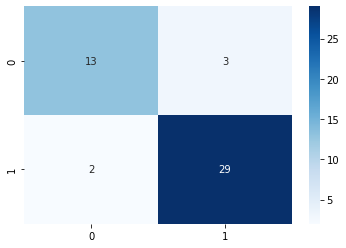

In [40]:
import seaborn as sns
sns.heatmap(confusion, annot=True, cmap='Blues')

In [41]:
model.save('simple_CNN_model.h5')